<a href="https://colab.research.google.com/github/brainhack-school2020/BHS-AuditoryMultimodal/blob/master/BHS_AuditoryMultimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auditory Multimodal

Add description of what is going on.

In [1]:
import pandas as pd
from os.path import join

from nipype.interfaces.io import BIDSDataGrabber
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.utility import Function

from bids import BIDSLayout
from bids.reports import BIDSReport
from bids_validator import BIDSValidator

from nilearn import datasets
from nilearn import plotting
from nilearn import image
from nilearn.image import mean_img
from nilearn.masking import apply_mask

# from nistats.first_level_model import FirstLevelModel

import glob
from pathlib import Path
import itertools


200603-13:53:03,404 nipype.utils INFO:
	 Running nipype version 1.4.2 (latest: 1.5.0)


## Preprocess data using fmriprep

`fmriprep-docker --fs-license-file /home/marcel/Documents/license.txt -vv --use-syn-sdc --use-aroma --resource-monitor --low-mem -w '/home/marcel/fmriprep-wd/wd' '/home/marcel/fmriprep-wd/ds000171-download' '/home/marcel/fmriprep-wd/ds000171-download/derivatives' participant`


In [2]:
# Load atlas

parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /home/marcel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


In [3]:
data_folder = '/home/marcel/fmriprep-wd/ds000171-download'
data_folder_pp = '/home/marcel/fmriprep-wd/ds000171-download/derivatives/fmriprep'

# Validate the input data
BIDSValidator().is_bids(data_folder)

False

After running fmriprep, bids does not recognise its output

adding ./derivatives to .bidsignore

# Check layout using BIDSLayout

In [4]:
layout = BIDSLayout(data_folder)

print(layout)
print(layout.get_subjects())
print(layout.get_modalities())
# print(layout.get_types())
print(layout.get_tasks())
layout.get( return_type='file')


BIDS Layout: .../fmriprep-wd/ds000171-download | Subjects: 1 | Sessions: 0 | Runs: 5
['control01']
[]
['music', 'nonmusic']


['/home/marcel/fmriprep-wd/ds000171-download/CHANGES',
 '/home/marcel/fmriprep-wd/ds000171-download/dataset_description.json',
 '/home/marcel/fmriprep-wd/ds000171-download/participants.tsv',
 '/home/marcel/fmriprep-wd/ds000171-download/README',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/anat/sub-control01_T1w.nii.gz',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-1_events.tsv',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-2_events.tsv',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz',
 '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-3_events.tsv',
 '/home/marce

In [5]:
# !tree -L 4 data_folder_pp

# Extract data using BIDSDataGrabber

In [6]:
useAll= False
useNSubj = 2

if useAll:
    subjIDs = layout.get_subjects()
else:
    subjIDs = layout.get_subjects()[:useNSubj]

bg = Node(BIDSDataGrabber(), name='bids-grabber')
bg.inputs.base_dir = data_folder
bg.iterables = ('subject', subjIDs)
res = bg.run()
res.outputs

200603-13:53:04,555 nipype.workflow INFO:
	 [Node] Setting-up "bids-grabber" in "/tmp/tmp_k5zz_79/bids-grabber".


INFO:nipype.workflow:[Node] Setting-up "bids-grabber" in "/tmp/tmp_k5zz_79/bids-grabber".


200603-13:53:04,563 nipype.workflow INFO:
	 [Node] Running "bids-grabber" ("nipype.interfaces.io.BIDSDataGrabber")


INFO:nipype.workflow:[Node] Running "bids-grabber" ("nipype.interfaces.io.BIDSDataGrabber")


200603-13:53:04,759 nipype.workflow INFO:
	 [Node] Finished "bids-grabber".


INFO:nipype.workflow:[Node] Finished "bids-grabber".



T1w = ['/home/marcel/fmriprep-wd/ds000171-download/sub-control01/anat/sub-control01_T1w.nii.gz']
bold = ['/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz', '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz', '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz', '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-nonmusic_run-4_bold.nii.gz', '/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-nonmusic_run-5_bold.nii.gz']

frmiprep output is incompatible with the current bids standar, we will need to load the thigs maually

(80, 80, 50, 105)
/home/marcel/fmriprep-wd/ds000171-download/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz


/home/marcel/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



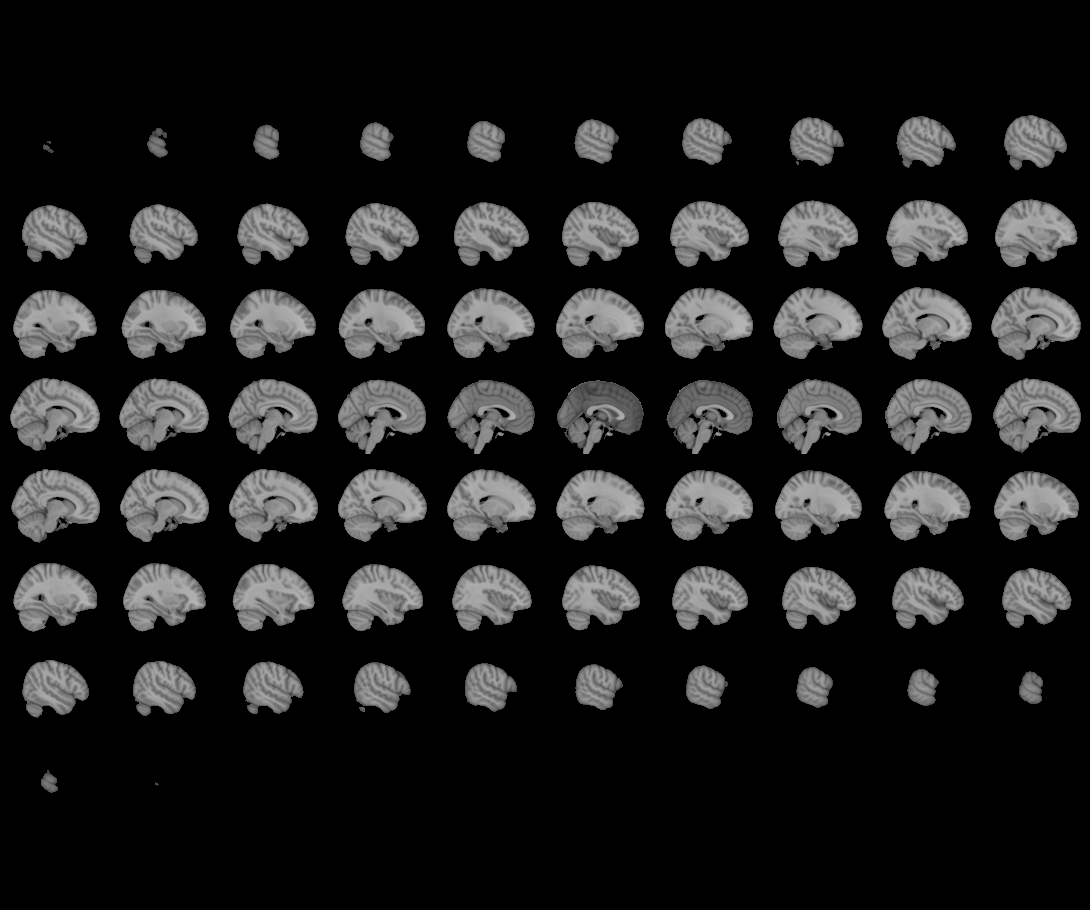
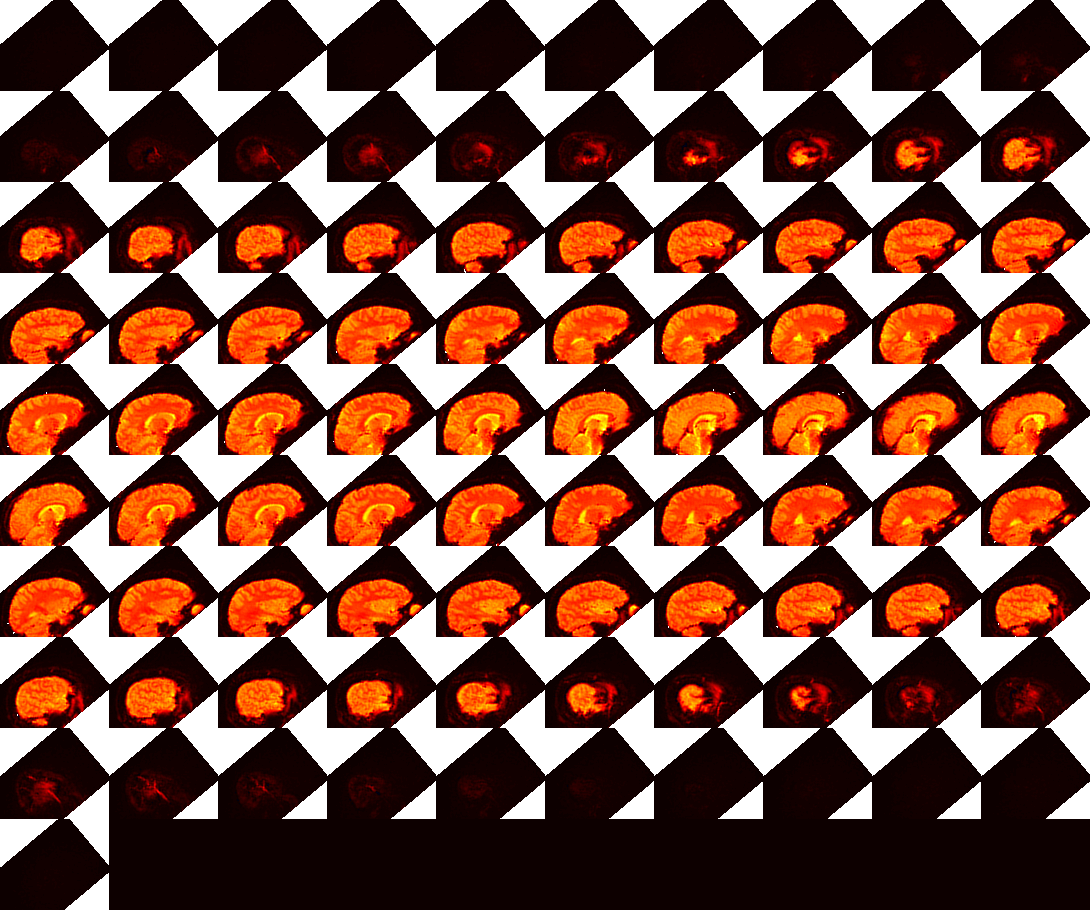

In [7]:
what_to_load = res.outputs.bold[0]

print(image.load_img(what_to_load).shape)

print(what_to_load)
example = image.index_img(what_to_load, 1)

example = image.index_img(what_to_load, 0)
plotting.view_img(example)
# plotting.view_img(example)
# Crash, report issue to git repo
# plotting.plot_stat_map(example)

# from nilearn.input_data import NiftiMasker
# masker = NiftiMasker(standardize=True, detrend=True)
# masker.fit(what_to_load)
# NiftiMasker(detrend=True, standardize=True)
# data = masker.transform(what_to_load)

Try to load the derivaties ... 

As we see using glass brain, this data is not aligned with the template

/home/marcel/miniconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


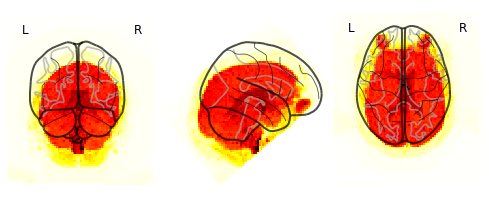

In [8]:
plotting.plot_glass_brain(example, threshold=3)

In [9]:
# ###
# # Prepare to extract the subjects. To facilitate loops, we first:
# # 1) Set subjects location
# # 2) Set the session of interest
# # 3) Determine subject list to iterate from
# # 4) Start the loop
# # 1)
# subjects_location = '/Users/stong3/Desktop/test_fmriprep_PAD/fmriprep/fmriprep/fmriprep/'
# connectivity_matrices_dir = '/Users/stong3/Desktop/test_fmriprep_PAD/derivatives/connectivity_matrices/'
# # 2) 
# subject_list = ['00001']
# session_list = ['BL00A']
# list_confounds = ['csf', 'white_matter', 'global_signal', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
# kind_connectivity = ['correlation']
# atlas = ['schaefer']
# for subject in subject_list:
#     for session in session_list:
#         print('Starting connectivity matrices extraction for subject ' + subject + ' for session ' + session)
#         #First, we need to import the paths where the fMRI pre-processed and confounds files are stored. They follow BIDS convention and depend on the path provided
#         #for the subject location. After fetching the paths, we print them.
#         print('Fetching the paths for the fMRI files and the confond files...')
#         pre_processed_fmri_file = subjects_location + 'sub-' + subject + '/ses-' + session + '/func/' + 'sub-' + subject + '_' + 'ses-' + session + '_task-rest_run-1_space-T1w_desc-preproc_bold.nii.gz'
#         full_confound_file_fmriprep = subjects_location + 'sub-' + subject + '/ses-' + session + '/func/' + 'sub-' + subject + '_' + 'ses-' + session + '_task-rest_run-1_desc-confounds_regressors.tsv'
#         print('The path for the fmri file is: ', pre_processed_fmri_file)
#         print('The path for the full confound file is: ', full_confound_file_fmriprep)

Processing sub /home/marcel/fmriprep-wd/ds000171-download/derivatives/fmriprep/sub-control01
/home/marcel/fmriprep-wd/ds000171-download/derivatives/fmriprep/sub-control01/anat/sub-control01_space-MNI152NLin6Asym_desc-brain_mask.nii.gz
sub-control01_task-music_run-2_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz
(91, 109, 91)
sub-control01_task-music_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz
(91, 109, 91)
sub-control01_task-music_run-3_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz
(91, 109, 91)
sub-control01_task-nonmusic_run-5_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz
(91, 109, 91)
sub-control01_task-nonmusic_run-4_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz
(91, 109, 91)


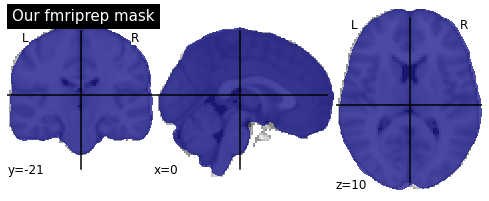

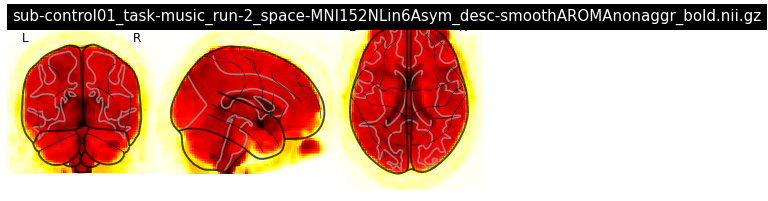

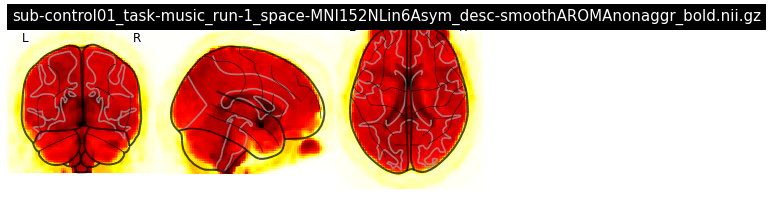

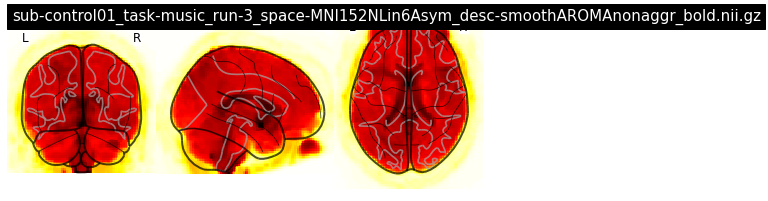

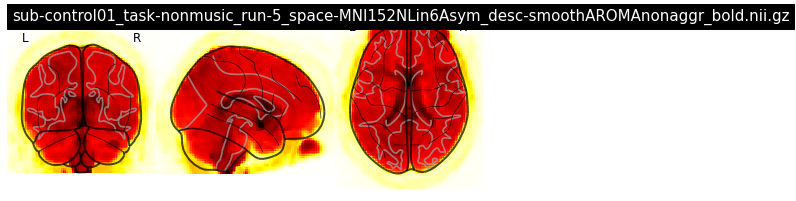

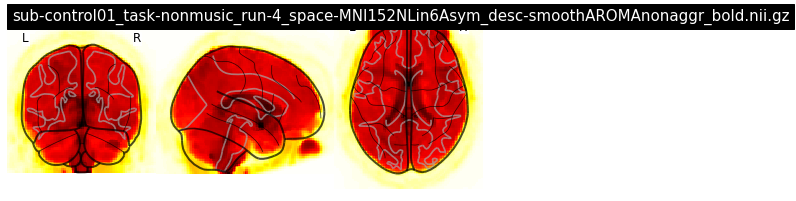

In [28]:
subjects_control = glob.glob(data_folder_pp+'/'+'sub-control*')
subjects_mdd = glob.glob('sub-mdd*')

mus_run = 'task-music'

nonmus_run = 'task-nonmusic'

# Example file name
# sub-control01_task-nonmusic_run-5_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold
for s in subjects_control:
    # load brain mask
    
    if Path(s).is_dir() is False:
        continue
    
    print('Processing sub '+s)
    try:
        mask_file = next(Path(s).rglob('*_space-MNI152NLin6Asym_desc-brain_mask.nii.gz'))
    except StopIteration:
        mask_file = ''
        print('mask file not found!')
        break
    
    print(mask_file)  

    plotting.plot_roi(str(mask_file), title='Our fmriprep mask')
    
    images = Path(s).rglob('*'+mus_run +'_*_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz')
    for img in images:
        print(img.name)
        # print first volume
        # plotting.plot_glass_brain(image.index_img(str(img), 0), threshold=5)
        # ploting mean
        img_mean = mean_img(str(img))
        print(img_mean.shape)
        plotting.plot_glass_brain(img_mean, threshold=None, title=img.name)
        
        # print masked first volume
        # does not work for now (mask and func data diffenret size)
        # masked_data = _apply_mask(str(img), str(mask_file))
        
        brain_mask()
        
    images = Path(s).rglob('*'+nonmus_run +'_*_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz')
    for img in images:
        print(img.name)
        # print first volume
        # plotting.plot_glass_brain(image.index_img(str(img), 0), threshold=5)
        # ploting mean
        img_mean = mean_img(str(img))
        print(img_mean.shape)
        plotting.plot_glass_brain(img_mean, threshold=None,title=img.name)
        
        # print masked first volume
        # does not work for now (mask and func data diffenret size)
        # masked_data = _apply_mask(str(img), str(mask_file))

# Basic Decoding

Processing sub /home/marcel/fmriprep-wd/ds000171-download/derivatives/fmriprep/sub-control01
sub-control01_task-music_run-2_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz
(91, 109, 91)
sub-control01_task-music_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz
(91, 109, 91)
sub-control01_task-music_run-3_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz
(91, 109, 91)
sub-control01_task-nonmusic_run-5_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz
(91, 109, 91)
sub-control01_task-nonmusic_run-4_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz
(91, 109, 91)


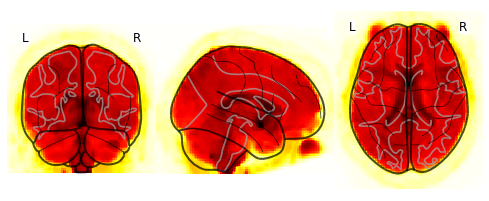

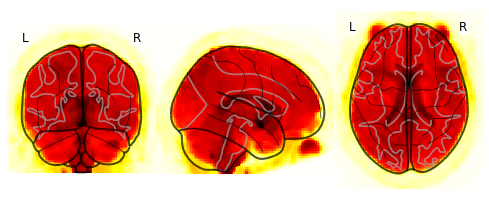

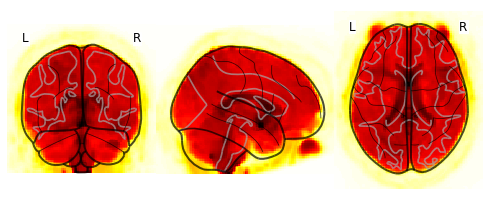

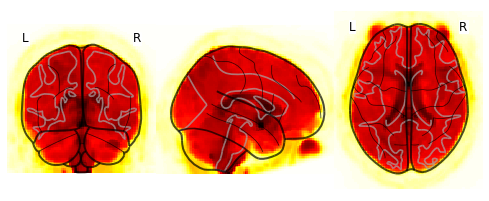

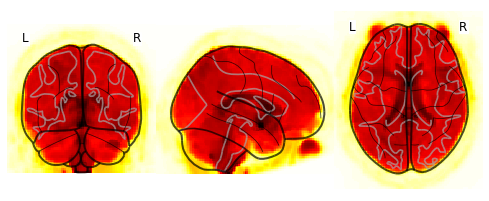

In [27]:
# Create 

df = pd.DataFrame(data={'img':[], 'events':[]})

for s in subjects_control:
    
    if Path(s).is_dir() is False:
        continue
    
    print('Processing sub '+s)
    
    images = Path(s).rglob('*'+mus_run)
    for img in images:
        print(img.name)
        plotting.plot_glass_brain(image.index_img(str(img), 0), threshold=5)
        # ploting mean
        img_mean = mean_img(str(img))
        print(img_mean.shape)
        plotting.plot_glass_brain(img_mean, threshold=None, )
        
        
        df.append({'img':str(img), 'events':[]})
        
    images = Path(s).rglob('*'+nonmus_run +'_*_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz')
    for img in images:
        print(img.name)
        # print first volume
        # plotting.plot_glass_brain(image.index_img(str(img), 0), threshold=5)
        # ploting mean
        img_mean = mean_img(str(img))
        print(img_mean.shape)
        plotting.plot_glass_brain(img_mean, threshold=None, )
        
        # print masked first volume
        # does not work for now (mask and func data diffenret size)
        # masked_data = _apply_mask(str(img), str(mask_file))

In [14]:
from nilearn.datasets import fetch_haxby
data_files = fetch_haxby()

# Load behavioral data
import pandas as pd
behavioral = pd.read_csv(data_files.session_target[0], sep=" ")

# Restrict to face and house conditions
conditions = behavioral['labels']
condition_mask = conditions.isin(['face', 'house'])

# Split data into train and test samples, using the chunks
condition_mask_train = (condition_mask) & (behavioral['chunks'] <= 6)
condition_mask_test = (condition_mask) & (behavioral['chunks'] > 6)

# Apply this sample mask to X (fMRI data) and y (behavioral labels)
# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily
from nilearn.image import index_img
func_filenames = data_files.func[0]
X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = conditions[condition_mask_train]
y_test = conditions[condition_mask_test]

# Compute the mean epi to be used for the background of the plotting
from nilearn.image import mean_img
background_img = mean_img(func_filenames)


Dataset created in /home/marcel/nilearn_data/haxby2001



Downloaded 2969 of 2969 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 408 of 408 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 291168628 of 291168628 bytes (100.0%,    0.0s remaining) ...done. (103 seconds, 1 min)
Extracting data from /home/marcel/nilearn_data/haxby2001/f33ff337e914bf7fded743c7107979f9/subj2-2010.01.14.tar.gz..... done.


In [25]:
condition_mask_train
func_filenames

'/home/marcel/nilearn_data/haxby2001/subj2/bold.nii.gz'